## Importing libraries

In [1]:
#Importing file paths
import os

#For managing dataframe
import pandas as pd
import numpy as np

#PyTorch
import torchaudio
import torch
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms.functional import crop
from torch.utils.data import Dataset
from torch import nn

#Metrics
import seaborn as sb
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import ConfusionMatrix

# Misc.
import PIL
import cv2
import warnings
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm_notebook

warnings.filterwarnings("ignore")

#Selecting device
device="cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device}")

Using cuda


## Image

In [13]:
im1=cv2.imread("Dataset/subset_1/manga1/bw/01.jpg")
im2=cv2.imread("sample_image_02.png")
print(im1.shape)
print(im2.shape)

(2359, 1665, 3)
(2448, 1665, 3)


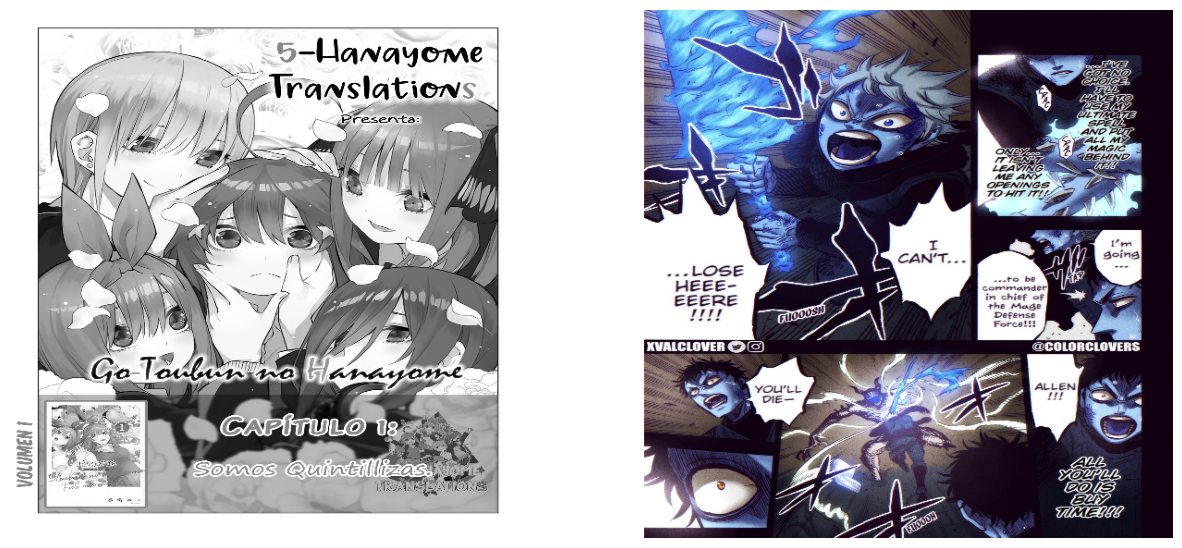

In [14]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(cv2.resize(im1,(572,572)))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(cv2.resize(im2,(572,572)))

## Model Formation

In [4]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=0) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=0) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=0) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=0) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=0) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=0) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=0) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=0) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=0) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=0) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=0)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=0)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=0)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=0)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=0)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=0)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=0)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=0)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        relu=nn.ReLU()
        # Encoder
        print(im.shape)
        
        xe11 = relu(self.e11(x))
        #print("xe11 shape:", xe11.shape)
    
        xe12 = relu(self.e12(xe11))
        #print("xe12 shape:", xe12.shape)
    
        xp1 = self.pool1(xe12)
        #print("xp1 shape:", xp1.shape)
    
        xe21 = relu(self.e21(xp1))
        #print("xe21 shape:", xe21.shape)
    
        xe22 = relu(self.e22(xe21))
        #print("xe22 shape:", xe22.shape)
    
        xp2 = self.pool2(xe22)
        #print("xp2 shape:", xp2.shape)
    
        xe31 = relu(self.e31(xp2))
        #print("xe31 shape:", xe31.shape)
    
        xe32 = relu(self.e32(xe31))
        #print("xe32 shape:", xe32.shape)
    
        xp3 = self.pool3(xe32)
        #print("xp3 shape:", xp3.shape)
    
        xe41 = relu(self.e41(xp3))
        #print("xe41 shape:", xe41.shape)
    
        xe42 = relu(self.e42(xe41))
        #print("xe42 shape:", xe42.shape)
    
        xp4 = self.pool4(xe42)
        #print("xp4 shape:", xp4.shape)
    
        xe51 = relu(self.e51(xp4))
        #print("xe51 shape:", xe51.shape)
    
        xe52 = relu(self.e52(xe51))
        #print("xe52 shape:", xe52.shape)
    
        # Decoder
        xu1 = self.upconv1(xe52)
        #print("xu1 shape:", xu1.shape)

        xe42_crop=torchvision.transforms.CenterCrop((56,56))
        xe42=xe42_crop(xe42)
        
        xu11 = torch.cat([xu1, xe42], dim=0)
        #xu11=xu1+xe42
        
        #print("xu11 shape:", xu11.shape)
    
        xd11 = relu(self.d11(xu11))
        #print("xd11 shape:", xd11.shape)
    
        xd12 = relu(self.d12(xd11))
        #print("xd12 shape:", xd12.shape)
    
        xu2 = self.upconv2(xd12)
        #print("xu2 shape:", xu2.shape)

        xe32_crop=torchvision.transforms.CenterCrop((104,104))
        xe32=xe32_crop(xe32)
        
        xu22 = torch.cat([xu2, xe32], dim=0)
        #print("xu22 shape:", xu22.shape)
    
        xd21 = relu(self.d21(xu22))
        #print("xd21 shape:", xd21.shape)
    
        xd22 = relu(self.d22(xd21))
        #print("xd22 shape:", xd22.shape)
    
        xu3 = self.upconv3(xd22)
        #print("xu3 shape:", xu3.shape)

        xe22_crop=torchvision.transforms.CenterCrop((200,200))
        xe22=xe22_crop(xe22)
        
        xu33 = torch.cat([xu3, xe22], dim=0)
        
        #print("xu33 shape:", xu33.shape)
    
        xd31 = relu(self.d31(xu33))
        #print("xd31 shape:", xd31.shape)
    
        xd32 = relu(self.d32(xd31))
        #print("xd32 shape:", xd32.shape)
    
        xu4 = self.upconv4(xd32)
        #print("xu4 shape:", xu4.shape)

        xe12_crop=torchvision.transforms.CenterCrop((392,392))
        xe12=xe12_crop(xe12)
        
        xu44 = torch.cat([xu4, xe12], dim=0)
        #print("xu44 shape:", xu44.shape)
    
        xd41 = relu(self.d41(xu44))
        #print("xd41 shape:", xd41.shape)
    
        xd42 = relu(self.d42(xd41))
        #print("xd42 shape:", xd42.shape)
    
        # Output layer
        out = self.outconv(xd42)
        #print("out shape:", out.shape)
    
        return out


In [5]:
model=UNet(3)
im=torch.rand((3,572,572))

In [24]:
with torch.inference_mode():
    test=model(im1).permute((1,2,0))

torch.Size([3, 572, 572])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


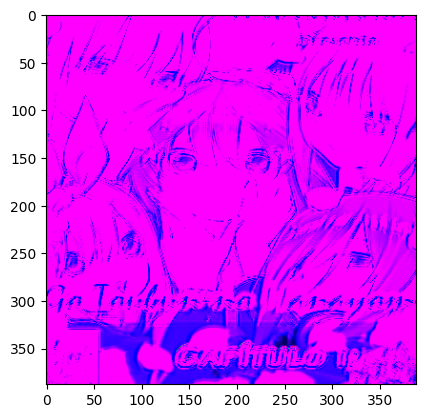

In [25]:
plt.imshow(test)

In [7]:
resizeIt=torchvision.transforms.Resize((572,572))

In [15]:
im1=torch.from_numpy(im1)

In [16]:
im1.shape

torch.Size([2359, 1665, 3])

In [17]:
im1=im1.permute((2,0,1))

In [18]:
im1=resizeIt(im1)

In [19]:
im1.shape

torch.Size([3, 572, 572])

In [23]:
im1=im1.type(torch.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


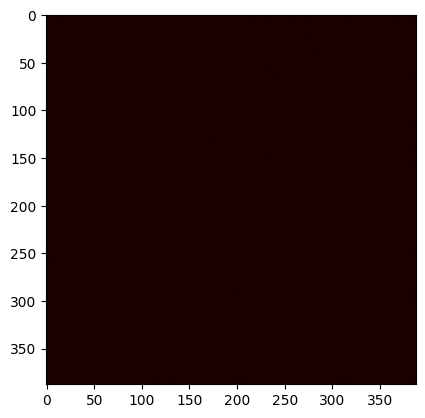

In [142]:
plt.imshow(test)

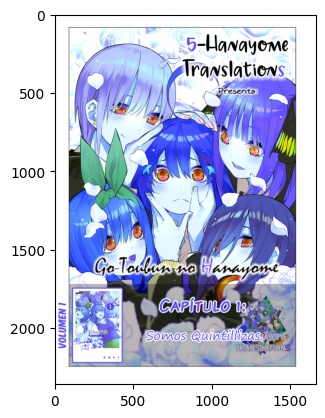

In [76]:
im1=torch.from_numpy(im1)
plt.imshow(im1)

In [71]:
c=torchvision.transforms.CenterCrop((500,500))

In [73]:
c(im1).shape

torch.Size([2359, 500, 500])

In [79]:
im_temp=im1.permute((2,0,1))

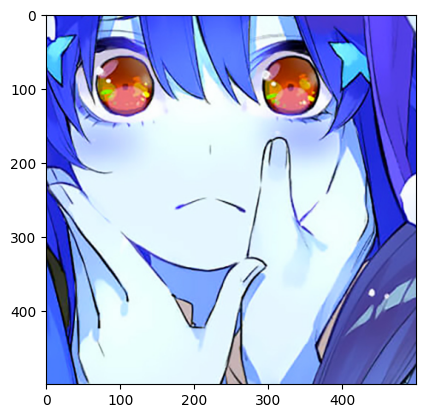

In [84]:
plt.imshow(c(im_temp).permute((1,2,0)))